# Element based HideNN-FEM

$ \forall v\in V(\Omega), $ find $u\in H(\Omega)$,
$$ \int_\Omega \nabla v \cdot \lambda(x) \nabla u = \int_\Omega f v  + \int_{\partial \Omega_N} g v$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

### a) Space interpolation

We recode 1D shape functions in HideNN-FEM (first order).


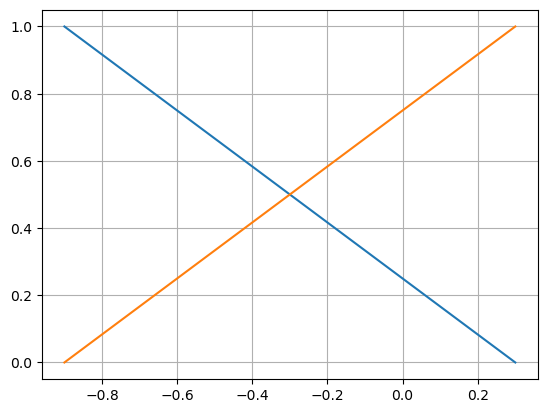

In [2]:
class mySF1D_elementBased(nn.Module):    # should inherit from nn.Module
    def __init__(self, left = -1.,  right = 1.):
        super().__init__()        # mandatory
        
        # our hyperparameters (arbitrary) :
        self.left = left
        self.right = right

        # pour transfert CUDA
        self.register_buffer('one', torch.tensor([1], dtype=torch.float32))

    def forward(self, x=None, training=False):  # define the function call
        if training : x = (self.left + self.right) / torch.tensor(2., requires_grad=True) # point de gauss pour le training
        #x.requires_grad = True # mystérieux
        sf1 = - (x - self.left) / (self.right - self.left) + self.one
        sf2 = (x - self.left)/(self.right - self.left)
        if training : return  sf1, sf2, self.right - self.left, x
        else : return  sf1, sf2


l, r =  -0.9, 0.3
mySF = mySF1D_elementBased(left = l, right = r)

XX = torch.linspace(l,r,100)
s1, s2 = mySF(XX)
plt.plot(XX.data, s1.data, XX.data, s2.data)
plt.grid()

### b) Mesh

In [3]:
N = 10
nodes = torch.linspace(0,10,N)
elements = torch.vstack([torch.arange(0,N-1),torch.arange(1,N)]).T

### c) Assembly

In [14]:
class interpolation1D(nn.Module):    # should inherit from nn.Module
    def __init__(self, nodes, elements, dirichlet=[]):
        super().__init__()        # mandatory
        
        self.nodes = nn.ParameterList([n for n in nodes]) # pour rendre entraînable
        for n in self.nodes:
            n.requires_grad = False
        self.nodalValues = nn.ParameterList([0 for n in self.nodes])

        self.dirichlet = dirichlet
        for i in self.dirichlet :
            self.nodalValues[i].requires_grad = False
        
        # our hyperparameters (arbitrary) :
        self.elements = elements

        self.Ne = len(elements)

        sfElts = []
        for i in range(self.Ne):
            sfElts.append(mySF1D_elementBased(left = self.nodes[elements[i,0]], right =  self.nodes[elements[i,1]]))
        
        self.shape_functions = nn.ModuleList(sfElts) # convertit en liste de module pytorch

        # pour transfert CUDA
        self.register_buffer('one', torch.tensor([1], dtype=torch.float32))

    def forward(self, x = None): 
        # le self.training est là pour calculer les intégrales avec les points de Gauss
        if self.training :
            k_elt = torch.arange(0,self.Ne)
        else :
            # liste de k
            k_elt = []
            for xx in x:
                for k in range(self.Ne):
                    sf = self.shape_functions[k]
                    if xx >= sf.left and xx <= sf.right:
                        k_elt.append(k)
                        break
        result , jac, XgList = [], [], []
        i = 0
        for k in k_elt:
            if self.training : 
                s0, s1, j, xg = self.shape_functions[k](training = True)
                jac.append(j); XgList.append(xg)
            else : s0, s1 = self.shape_functions[k](x[i])
            u0 = self.nodalValues[self.elements[k,0]]
            u1 = self.nodalValues[self.elements[k,1]]
            result.append(u0 * s0 + u1 * s1)
            i+=1
        if  self.training : return result, jac, XgList
        return torch.vstack(result)

In [15]:
myInterp = interpolation1D(nodes, elements)


In [22]:
myInterp.train()
for i in range(len(myInterp.nodalValues)):
    myInterp.nodalValues[i] = torch.sin(myInterp.nodes[i])

res, jac, x = myInterp()



(tensor(0.8066, grad_fn=<AddBackward0>),)

# Let's try deriving a single output and not the cat version ! 

In [28]:
dres_0 = torch.autograd.grad(res[0], x[0], grad_outputs=torch.ones_like(x[0]), create_graph=True)

dres_0

dres_tot = torch.autograd.grad(torch.vstack(res), torch.vstack(x), grad_outputs=torch.ones_like(torch.vstack(x)), create_graph=True)

dres_tot

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

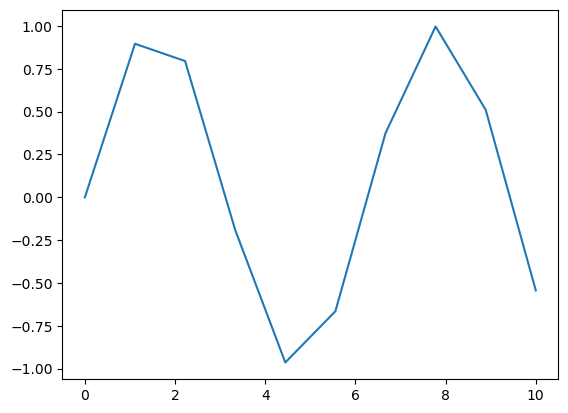

In [7]:
XX = torch.linspace(0,10, 100)
res = []
myInterp.train(False)
res = myInterp(XX)
plt.plot(XX.data, res.data)

### d) Entrainement (loss)

In [8]:
def PotentialEnergy(u,x,f,J,dirichlet=[]):
    """Computes the potential energy of the Beam, which will be used as the loss of the HiDeNN"""
    print(u.requires_grad)
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # on somme aux points (on espère de Gauss)
# Vectorised calculation of the integral terms
    wg = 1
    int_term1 =  0.5 * du_dx * wg * J
    int_term2 =  f(x) * J * u

    # Vectorised calculation of the integral using the trapezoidal rule
    integral = torch.sum(int_term1 - int_term2)
    integral += 1e6 * dirichlet **2
    return integral

def f(x):
    return 1 #-x*(x-10)

In [9]:
optimizer = torch.optim.Adam(myInterp.parameters(), lr = 1)

# Training
Nepoch = 2000
lossList = []
lossTraining = []
myInterp.train()
for i in range(Nepoch):
    res, jac, x = myInterp()
    loss = PotentialEnergy(res,x,f,jac, myInterp.nodalValues[0])
    optimizer.zero_grad()    # necessaire pour réinitialiser les gradients
    loss.backward()          # compute the gradients (chain rule)
    optimizer.step()
    lossTraining.append(loss.data)
    print(f"{i = } | loss = {loss.data :.2f}", end = "\r")

True


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
for name, param in myInterp.named_parameters():
    if param.requires_grad:
        print((name, param.data))

In [11]:
l, r =  -torch.tensor(0.9), torch.tensor(0.3)
mySF = mySF1D_elementBased(left = l, right = r)

#x = torch.tensor(2., requires_grad = True)
sf1, sf2, jac, x = mySF(training=True)
dsf1 = torch.autograd.grad(sf1, x, grad_outputs=torch.ones_like(sf1), create_graph=True)
dsf2 = torch.autograd.grad(sf2, x, grad_outputs=torch.ones_like(sf2), create_graph=True)



In [12]:
dsf2

(tensor(0.8333),)

In [13]:
dsf1

(tensor(-0.8333),)